This notebook will briefly present _Bayesian spam filtering_, which is an established and effective technique for spam filtering.  The basic idea is to look at documents as _bags of words_ (that is, as mappings of words to frequencies, disregarding ordering).  The underlying assumption is that spam and legitimate documents will have different distributions of words, and that we'll be able to rate the probability that a given set of words came from a legitimate document or a spam document. 



In [1]:
import pandas as pd
import numpy as np
data = pd.read_parquet("data/training.parquet")

We'll start by splitting our data into randomly-selected train and test sets.

In [2]:
from sklearn import model_selection
train, test = model_selection.train_test_split(data)

Our feature extraction pipeline is very simple:  we'll use a _bag-of-words_ model in which we represent texts as dictionaries of word counts.  Furthermore, we'll use feature hashing so that we store word counts in a array of hash buckets rather than as an explicit dictionary.

In [3]:
from sklearn.feature_extraction import text as text_feature

hv = text_feature.HashingVectorizer(norm='l1', alternate_sign=False)
hashed_features = hv.transform(train.text.values)

From there, we'll use the multinomial naive Bayes classifier in scikit-learn, which will train a model to identify which words (really, which hash values of words) are most likely to distinguish between legitimate and spam messages.

In [4]:
from sklearn import naive_bayes

nb = naive_bayes.MultinomialNB()
nb.fit(hashed_features, train.label.values)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Once we've fit our model, we can evaluate its accuracy on our training and test sets.

In [5]:
nb.score(hashed_features, train.label.values)

0.9770333333333333

In [6]:
test_features = hv.transform(test.text.values)
nb.score(test_features, test.label.values)

0.9793

As you know, raw accuracy isn't the most useful metric to evaluate a binary classifier.  In order to visualize how the naive Bayes classifier performs overall, we'll plot a confusion matrix.

In [7]:
from mlworkflows import plot

In [8]:
df, chart = plot.binary_confusion_matrix(test.label.values, nb.predict(test_features))

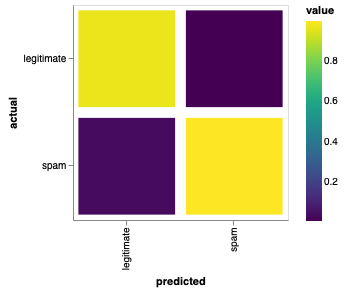

In [9]:
chart

We can also inspect the performance in tabular form.

In [10]:
df

,actual,predicted,raw_count,value
0,legitimate,legitimate,4775,0.964062
1,spam,legitimate,178,0.035938
2,legitimate,spam,29,0.005746
3,spam,spam,5018,0.994254


Finally, we can produce a report showing us the precision and recall for each class, as well as an [f<sub>1</sub>-score](https://en.wikipedia.org/wiki/F1_score).

In [11]:
from sklearn.metrics import classification_report
print(classification_report(test.label.values, nb.predict(test_features)))

             precision    recall  f1-score   support

 legitimate       0.99      0.96      0.98      4953
       spam       0.97      0.99      0.98      5047

avg / total       0.98      0.98      0.98     10000



### Exercises

0.  The preprocessing step in this notebook is virtually nonexistent.  How might you use spaCy to have a more robust preprocessing pipeline?
1.  The feature extraction pipeline in this notebook uses hashed vectors with 2<sup>20</sup> elements.  Run some experiments to identify whether or not smaller vectors would still provide acceptable performance.
2.  Bayesian document classification is an established technique that has worked well in practice for a long time.  A common way to fool Bayesian spam filters is to append a lot of legitimate text to the end of a spam document.  What sort of features would you extract in order to train a classifier that could identify spam messages that were using this trick?